In [181]:
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
#import cv2
from numpy import zeros, newaxis,inf
import glob
import skimage
import skimage.io

def readPFM(file):### for ground truth
    file = open(file, 'rb')
    color = None
    width = None
    height = None
    scale = None
    endian = None

    #header = file.readline().rstrip()
    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True    
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    #dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline())
    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    #scale = float(file.readline().rstrip())
    scale = float(file.readline().decode('utf-8').rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)
    
    data = np.reshape(data, shape)
    data = np.flipud(data) # flip imageß
    return data, scale

'''
Save a Numpy array to a PFM file.
'''


'\nSave a Numpy array to a PFM file.\n'

In [182]:
def GetBilinearPixel(imArr, posR, posC):
    out = []

    #Get integer and fractional parts of numbers
    modCi = int(posC)
    modCf = posC - modCi
    modCiPlusOneLim = min(modCi+1,imArr.shape[1]-1)

    #Get pixels in two side
    for chan in range(imArr.shape[2]):
        bl = imArr[posR, modCi, chan]
        br = imArr[posR, modCiPlusOneLim, chan]
        #Calculate interpolation
        b = modCf * br + (1. - modCf) * bl
        #out.append(int(b+0.5))
        out.append(b)  
    return out 

def getWarpedImageWithBilinear(right,disp):
    disp[disp==inf]=0
    leftHat = np.zeros_like(right)
    for r in range(leftHat.shape[0]):
        for c in range(leftHat.shape[1]):         
            orir = r  #Find position in original image
            oric = max(c - disp[r,c],0)
            leftHat[r, c] = GetBilinearPixel(right, orir, oric)
    return leftHat

def getErrorImage(leftHat,left):
    return abs(leftHat-left)

In [183]:
path_data = '/home/tiuser/Documents/Data_summer_Jing/KITTI_2015/'

training_data_folder_path_list = glob.glob(path_data+'left/*.png')
training_data_folder_path_list.sort()

training_data_folder_path_list_r = glob.glob(path_data+'right/*.png')
training_data_folder_path_list_r.sort()

disp_path_list = glob.glob(path_data+'sdeOut_png/*.png')
disp_path_list.sort()

groundtruth_folder_path_list = glob.glob(path_data+'gt_png/*.png')
groundtruth_folder_path_list.sort()

In [246]:
data_list = []
ground_truth_list =[]
mask_list = []

leftMargin = 131
rightMargin = 4
topMargin = 4
botMargin = 4


for i in range(len(disp_path_list)):
    count = 0
    #print ('a',disp_path_list[i])
    #print ('b',training_data_folder_path_list[i])
    #print ('d',training_data_folder_path_list_r[i])
    #print ('c',groundtruth_folder_path_list[i])
    if training_data_folder_path_list[i][-7:-4] == disp_path_list[i][-17:-14]:
        count+=1
        tmp_disp = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
        tmp_disp = tmp_disp[topMargin:-botMargin, leftMargin:-rightMargin]
        #print(tmp_disp.max(),'lala')
    if training_data_folder_path_list[i][-7:-4] ==groundtruth_folder_path_list[i][-7:-4]:
        count+=1
        tmp_ground_true = skimage.io.imread(groundtruth_folder_path_list[i]).astype('uint16')/256.0
        tmp_ground_true = tmp_ground_true[topMargin:-botMargin, leftMargin:-rightMargin]
        test_gt = skimage.io.imread(groundtruth_folder_path_list[i]).astype('uint16')
        #print(tmp_ground_true.shape)
        #print(tmp_ground_true.max(),'laaala')
    print (i)
    if count==2:
        left_image = plt.imread(training_data_folder_path_list[i]) 
        right_image = plt.imread(training_data_folder_path_list_r[i])
        
        left_image = left_image[topMargin:-botMargin, leftMargin:-rightMargin,:]
        right_image = right_image[topMargin:-botMargin, leftMargin:-rightMargin,:]
        
        warp_left = getWarpedImageWithBilinear(right_image,tmp_disp)
        error_left = getErrorImage(warp_left,left_image)
        tmp_combine = np.dstack((left_image,right_image,warp_left,error_left,tmp_disp))
        data_list.append(tmp_combine)
        
        tmp_ground_true[tmp_ground_true == inf] =0 
        ground_truth_list.append(tmp_ground_true[:,:, newaxis])
        mask_list.append(((tmp_ground_true>0)*1.0)[:,:, newaxis])
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [247]:
print(data_np[1].shape[:2])

(240, 1232)


In [248]:
data_np = np.array(data_list)
ground_truth_np = np.array(ground_truth_list)
mask_np = np.array(mask_list)
print(data_np.shape)
print(ground_truth_np.shape)
print(mask_np.shape)

(200, 367, 1105, 13)
(200, 367, 1105, 1)
(200, 367, 1105, 1)


In [249]:
# check if any mismatch happened
for i in range(200):
    if data_np[i].shape[:2] != ground_truth_np[i].shape[:2] \
        or data_np[i].shape[:2] != mask_np[i].shape[:2] \
        or data_np[i].shape[:2] != mask_np[i].shape[:2]:
        print(i)
        print(data_np[i].shape)
        print(ground_truth_np[i].shape)
        print(mask_np[i].shape)

In [250]:
from sklearn.utils import shuffle
data_np, ground_truth_np, mask_np = shuffle(data_np, ground_truth_np, mask_np, random_state=42)
print("complete shuffling")

complete shuffling


In [251]:
print(data_np[0].shape)

(367, 1105, 13)


In [252]:
split_point = 160

data_np_t, ground_truth_np_t, mask_np_t = data_np[:split_point], ground_truth_np[:split_point], mask_np[:split_point]
data_np_v, ground_truth_np_v, mask_np_v = data_np[split_point:], ground_truth_np[split_point:], mask_np[split_point:]


In [253]:

def generator_stack(data_np, ground_truth_np, mask_np):
    num_samples = data_np.shape[0]
    while 1: # Loop forever so the generator never terminates
        #data, label =shuffle(data, label, random_state=33)
        for offset in range(0, num_samples): 
            if offset == num_samples - 1:
                data_np, ground_truth_np, mask_np = shuffle(data_np, ground_truth_np, mask_np, random_state=33)
                yield [(data_np[offset])[newaxis,:,:,:],(mask_np[offset])[newaxis,:,:,:]],(ground_truth_np[offset])[newaxis,:,:,:]
                break
            #print(folder_path_list)
            yield [(data_np[offset])[newaxis,:,:,:],(mask_np[offset])[newaxis,:,:,:]],(ground_truth_np[offset])[newaxis,:,:,:]
            
            
            
train_generator = generator_stack(data_np_t, ground_truth_np_t, mask_np_t)
val_generator = generator_stack(data_np_v, ground_truth_np_v, mask_np_v)

In [254]:
print('ok')

ok


In [358]:
print (data_np_v.shape)

(40, 367, 1105, 13)


In [361]:
skimage.io.imsave('example_left.png',(data_np_v[0][:,:,0:3]))
skimage.io.imsave('example_right.png',(data_np_v[0][:,:,3:6]))
skimage.io.imsave('example_warped.png',(data_np_v[0][:,:,6:9]))
skimage.io.imsave('example_error.png',(data_np_v[0][:,:,9:12]))

/home/tiuser/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
skimage.io.imsave('example_left.png',(tmp_res*256).astype('uint16'))

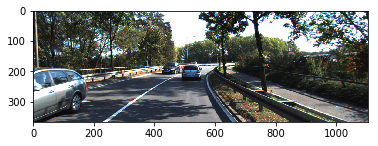

In [362]:
plt.imshow(data_np_v[0][:,:,0:3])

# model 

In [256]:
from keras.models import Sequential, load_model, Model
from keras.layers import Input,Activation,  Dense,Conv2D,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPooling2D,BatchNormalization, Dropout
from keras.layers import Add,Subtract,Multiply,Concatenate, Flatten, Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.models import model_from_json

# add one layer of 3*3 kernel


In [347]:
# model #glorot_uniform  -> 180
input_shape_c = (None, None,13)
input_shape = (None, None,1)

input_image  = Input(shape=input_shape_c,name='input_image')
mask = Input(shape=input_shape,name='mask')


conv1 = Conv2D(filters = 64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu",name='L1',kernel_initializer='glorot_uniform')(input_image)
conv1 = Conv2D(filters = 32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu",name='L2',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L3',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L4',kernel_initializer='glorot_uniform')(conv1)



mask_out = Multiply(name='mask_out')([mask,conv1])

model = Model(inputs=[input_image,mask], outputs=mask_out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, None, None, 6 40832       input_image[0][0]                
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, None, None, 3 51232       L1[0][0]                         
__________________________________________________________________________________________________
L3 (Conv2D)                     (None, None, None, 3 9248        L2[0][0]                         
__________________________________________________________________________________________________
mask (Inpu

In [348]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.fit(x=[data_np,mask_np], y=ground_truth_np, batch_size=1, epochs=10, verbose=1, validation_split=0.1, shuffle=True,callbacks = callbacks)


model.fit_generator(train_generator, steps_per_epoch=split_point , validation_data=val_generator, validation_steps = 200-split_point, epochs=120, callbacks=callbacks, verbose = 1)

Epoch 1/120
160/160 [==============================] - 21s 131ms/step - loss: 1.1629 - val_loss: 0.3114
Epoch 2/120
160/160 [==============================] - 22s 135ms/step - loss: 0.3233 - val_loss: 0.2554
Epoch 3/120
160/160 [==============================] - 21s 130ms/step - loss: 0.3377 - val_loss: 0.2625
Epoch 4/120
160/160 [==============================] - 21s 129ms/step - loss: 0.2900 - val_loss: 0.2891
Epoch 5/120
160/160 [==============================] - 21s 130ms/step - loss: 0.2892 - val_loss: 0.2999
Epoch 6/120
160/160 [==============================] - 22s 136ms/step - loss: 0.3177 - val_loss: 0.2322
Epoch 7/120
160/160 [==============================] - 21s 131ms/step - loss: 0.2799 - val_loss: 0.2397
Epoch 8/120
160/160 [==============================] - 21s 131ms/step - loss: 0.3004 - val_loss: 0.3277
Epoch 9/120
160/160 [==============================] - 21s 131ms/step - loss: 0.2931 - val_loss: 0.3168
Epoch 10/120
160/160 [==============================] - 22s 136m

In [349]:
result = []
result_dense = []
tmp_res = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
tmp_res = np.zeros_like(tmp_res)
tmp_sde = np.zeros_like(tmp_res)
tmp_gt = np.zeros_like(tmp_res)
for i in range(200-split_point):
    mask_r = mask_np_v[i][newaxis,:,:,:]>-1
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    tmp_r_dense = model.predict([data_np_v[i][newaxis,:,:,:],mask_r], verbose=0, steps=None)
    tmp_res[topMargin:-botMargin, leftMargin:-rightMargin] = tmp_r_dense[0,:,:,0]
    tmp_gt[topMargin:-botMargin, leftMargin:-rightMargin] = ground_truth_np_v[i][:,:,0]
    tmp_sde[topMargin:-botMargin, leftMargin:-rightMargin] = data_np_v[i][:,:,-1]
    
    skimage.io.imsave('./val_Results_4layers_V3/val_'+str(i)+'_pnn.png',(tmp_res*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers_V3/val_'+str(i)+'_gt.png',(tmp_gt*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers_V3/val_'+str(i)+'_sde.png',(tmp_sde*256).astype('uint16'))
    
    result.append(tmp_r)
    result_dense.append(tmp_r_dense)
    
print(len(result))
print(len(result_dense))

40
40


# 4 layers_V2: 32 7 *7+48 5 *5 +48 3 *3 +32 3 *3 +1 3*3

In [344]:
# model #glorot_uniform  -> 180
input_shape_c = (None, None,13)
input_shape = (None, None,1)

input_image  = Input(shape=input_shape_c,name='input_image')
mask = Input(shape=input_shape,name='mask')


conv1 = Conv2D(filters = 32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu",name='L1',kernel_initializer='glorot_uniform')(input_image)
conv1 = Conv2D(filters = 48, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu",name='L2',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 48, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L3',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L4',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L5',kernel_initializer='glorot_uniform')(conv1)


mask_out = Multiply(name='mask_out')([mask,conv1])

model = Model(inputs=[input_image,mask], outputs=mask_out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, None, None, 3 20416       input_image[0][0]                
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, None, None, 4 38448       L1[0][0]                         
__________________________________________________________________________________________________
L3 (Conv2D)                     (None, None, None, 4 20784       L2[0][0]                         
__________________________________________________________________________________________________
L4 (Conv2D

In [345]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.fit(x=[data_np,mask_np], y=ground_truth_np, batch_size=1, epochs=10, verbose=1, validation_split=0.1, shuffle=True,callbacks = callbacks)


model.fit_generator(train_generator, steps_per_epoch=split_point , validation_data=val_generator, validation_steps = 200-split_point, epochs=120, callbacks=callbacks, verbose = 1)

Epoch 1/120
160/160 [==============================] - 23s 145ms/step - loss: 1.3202 - val_loss: 0.3298
Epoch 2/120
160/160 [==============================] - 23s 144ms/step - loss: 0.3194 - val_loss: 0.2761
Epoch 3/120
160/160 [==============================] - 22s 140ms/step - loss: 0.3088 - val_loss: 0.2881
Epoch 4/120
160/160 [==============================] - 22s 141ms/step - loss: 0.2805 - val_loss: 0.2738
Epoch 5/120
160/160 [==============================] - 22s 141ms/step - loss: 0.2706 - val_loss: 0.2516
Epoch 6/120
160/160 [==============================] - 24s 148ms/step - loss: 0.2759 - val_loss: 0.2318
Epoch 7/120
160/160 [==============================] - 23s 141ms/step - loss: 0.2833 - val_loss: 0.2511
Epoch 8/120
160/160 [==============================] - 23s 142ms/step - loss: 0.2881 - val_loss: 0.2816
Epoch 9/120
160/160 [==============================] - 23s 142ms/step - loss: 0.2524 - val_loss: 0.2485
Epoch 10/120
160/160 [==============================] - 23s 147m

In [346]:
result = []
result_dense = []
tmp_res = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
tmp_res = np.zeros_like(tmp_res)
tmp_sde = np.zeros_like(tmp_res)
tmp_gt = np.zeros_like(tmp_res)
for i in range(200-split_point):
    mask_r = mask_np_v[i][newaxis,:,:,:]>-1
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    tmp_r_dense = model.predict([data_np_v[i][newaxis,:,:,:],mask_r], verbose=0, steps=None)
    tmp_res[topMargin:-botMargin, leftMargin:-rightMargin] = tmp_r_dense[0,:,:,0]
    tmp_gt[topMargin:-botMargin, leftMargin:-rightMargin] = ground_truth_np_v[i][:,:,0]
    tmp_sde[topMargin:-botMargin, leftMargin:-rightMargin] = data_np_v[i][:,:,-1]
    
    skimage.io.imsave('./val_Results_4layers_V2/val_'+str(i)+'_pnn.png',(tmp_res*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers_V2/val_'+str(i)+'_gt.png',(tmp_gt*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers_V2/val_'+str(i)+'_sde.png',(tmp_sde*256).astype('uint16'))
    
    result.append(tmp_r)
    result_dense.append(tmp_r_dense)
    
print(len(result))
print(len(result_dense))

40
40


# 4 layers (32 7*7 32 5*5 32 3*3 1 3*3)

In [336]:
# model #glorot_uniform  -> 180
input_shape_c = (None, None,13)
input_shape = (None, None,1)

input_image  = Input(shape=input_shape_c,name='input_image')
mask = Input(shape=input_shape,name='mask')


conv1 = Conv2D(filters = 32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu",name='L1',kernel_initializer='glorot_uniform')(input_image)
conv1 = Conv2D(filters = 32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu",name='L2',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L3',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L4',kernel_initializer='glorot_uniform')(conv1)


mask_out = Multiply(name='mask_out')([mask,conv1])

model = Model(inputs=[input_image,mask], outputs=mask_out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, None, None, 3 20416       input_image[0][0]                
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, None, None, 3 25632       L1[0][0]                         
__________________________________________________________________________________________________
L3 (Conv2D)                     (None, None, None, 3 9248        L2[0][0]                         
__________________________________________________________________________________________________
mask (Inpu

In [337]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=18,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=7,
                               verbose=1,
                               min_delta=1e-3),
            ]


In [338]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.fit(x=[data_np,mask_np], y=ground_truth_np, batch_size=1, epochs=10, verbose=1, validation_split=0.1, shuffle=True,callbacks = callbacks)


model.fit_generator(train_generator, steps_per_epoch=split_point , validation_data=val_generator, validation_steps = 200-split_point, epochs=120, callbacks=callbacks, verbose = 1)

Epoch 1/120
160/160 [==============================] - 17s 106ms/step - loss: 1.3218 - val_loss: 0.3367
Epoch 2/120
160/160 [==============================] - 17s 108ms/step - loss: 0.3500 - val_loss: 0.3141
Epoch 3/120
160/160 [==============================] - 16s 103ms/step - loss: 0.3316 - val_loss: 0.3072
Epoch 4/120
160/160 [==============================] - 16s 102ms/step - loss: 0.3186 - val_loss: 0.3084
Epoch 5/120
160/160 [==============================] - 16s 102ms/step - loss: 0.3070 - val_loss: 0.3349
Epoch 6/120
160/160 [==============================] - 17s 108ms/step - loss: 0.3034 - val_loss: 0.2363
Epoch 7/120
160/160 [==============================] - 16s 103ms/step - loss: 0.2932 - val_loss: 0.3390
Epoch 8/120
160/160 [==============================] - 17s 104ms/step - loss: 0.2821 - val_loss: 0.2898
Epoch 9/120
160/160 [==============================] - 17s 103ms/step - loss: 0.2849 - val_loss: 0.2802
Epoch 10/120
160/160 [==============================] - 17s 108m

In [339]:
result = []
result_dense = []
tmp_res = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
tmp_res = np.zeros_like(tmp_res)
tmp_sde = np.zeros_like(tmp_res)
tmp_gt = np.zeros_like(tmp_res)
for i in range(200-split_point):
    mask_r = mask_np_v[i][newaxis,:,:,:]>-1
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    tmp_r_dense = model.predict([data_np_v[i][newaxis,:,:,:],mask_r], verbose=0, steps=None)
    tmp_res[topMargin:-botMargin, leftMargin:-rightMargin] = tmp_r_dense[0,:,:,0]
    tmp_gt[topMargin:-botMargin, leftMargin:-rightMargin] = ground_truth_np_v[i][:,:,0]
    tmp_sde[topMargin:-botMargin, leftMargin:-rightMargin] = data_np_v[i][:,:,-1]
    
    skimage.io.imsave('./val_Results_4layers/val_'+str(i)+'_pnn.png',(tmp_res*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers/val_'+str(i)+'_gt.png',(tmp_gt*256).astype('uint16'))
    skimage.io.imsave('./val_Results_4layers/val_'+str(i)+'_sde.png',(tmp_sde*256).astype('uint16'))
    
    result.append(tmp_r)
    result_dense.append(tmp_r_dense)
    
print(len(result))
print(len(result_dense))

40
40


# original 3 layers

In [257]:
# model #glorot_uniform  -> 180
input_shape_c = (None, None,13)
input_shape = (None, None,1)

input_image  = Input(shape=input_shape_c,name='input_image')
mask = Input(shape=input_shape,name='mask')


conv1 = Conv2D(filters = 64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu",name='L1',kernel_initializer='glorot_uniform')(input_image)
conv1 = Conv2D(filters = 32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu",name='L2',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L3',kernel_initializer='glorot_uniform')(conv1)


mask_out = Multiply(name='mask_out')([mask,conv1])

model = Model(inputs=[input_image,mask], outputs=mask_out)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, None, None, 6 40832       input_image[0][0]                
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, None, None, 3 51232       L1[0][0]                         
__________________________________________________________________________________________________
mask (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L3 (Conv2D

In [258]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=18,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=7,
                               verbose=1,
                               min_delta=1e-3),
            ]



In [288]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.fit(x=[data_np,mask_np], y=ground_truth_np, batch_size=1, epochs=10, verbose=1, validation_split=0.1, shuffle=True,callbacks = callbacks)


model.fit_generator(train_generator, steps_per_epoch=split_point , validation_data=val_generator, validation_steps = 200-split_point, epochs=120, callbacks=callbacks, verbose = 1)



Epoch 1/120
160/160 [==============================] - 19s 119ms/step - loss: 0.2886 - val_loss: 0.2278
Epoch 2/120
160/160 [==============================] - 19s 118ms/step - loss: 0.2485 - val_loss: 0.2853
Epoch 3/120
160/160 [==============================] - 19s 119ms/step - loss: 0.2475 - val_loss: 0.2454
Epoch 4/120
160/160 [==============================] - 20s 124ms/step - loss: 0.2612 - val_loss: 0.2422
Epoch 5/120
160/160 [==============================] - 19s 120ms/step - loss: 0.2604 - val_loss: 0.2272
Epoch 6/120
160/160 [==============================] - 19s 119ms/step - loss: 0.2604 - val_loss: 0.2951
Epoch 7/120
160/160 [==============================] - 19s 119ms/step - loss: 0.2654 - val_loss: 0.2533
Epoch 8/120
160/160 [==============================] - 20s 126ms/step - loss: 0.2541 - val_loss: 0.2126
Epoch 9/120
160/160 [==============================] - 19s 120ms/step - loss: 0.2698 - val_loss: 0.2360
Epoch 10/120
160/160 [==============================] - 19s 120m

In [335]:
result = []
result_dense = []
tmp_res = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
tmp_res = np.zeros_like(tmp_res)
tmp_sde = np.zeros_like(tmp_res)
tmp_gt = np.zeros_like(tmp_res)
for i in range(200-split_point):
    mask_r = mask_np_v[i][newaxis,:,:,:]>-1
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    tmp_r_dense = model.predict([data_np_v[i][newaxis,:,:,:],mask_r], verbose=0, steps=None)
    tmp_res[topMargin:-botMargin, leftMargin:-rightMargin] = tmp_r_dense[0,:,:,0]
    tmp_gt[topMargin:-botMargin, leftMargin:-rightMargin] = ground_truth_np_v[i][:,:,0]
    tmp_sde[topMargin:-botMargin, leftMargin:-rightMargin] = data_np_v[i][:,:,-1]
    
    skimage.io.imsave('./val_Results/val_'+str(i)+'_pnn.png',(tmp_res*256).astype('uint16'))
    skimage.io.imsave('./val_Results/val_'+str(i)+'_gt.png',(tmp_gt*256).astype('uint16'))
    skimage.io.imsave('./val_Results/val_'+str(i)+'_sde.png',(tmp_sde*256).astype('uint16'))
    
    result.append(tmp_r)
    result_dense.append(tmp_r_dense)
    
print(len(result))
print(len(result_dense))

40
40


In [334]:
print (tmp_r_dense[0,:,:,0].shape)

(367, 1105)


In [328]:
tmp_res = skimage.io.imread(disp_path_list[i]).astype('uint16')/256.0
tmp_res = np.zeros_like(tmp_res)
print (tmp_res.shape)

(375, 1240)


# show some ex results

In [290]:
result[0].shape

(1, 367, 1105, 1)

In [291]:
result[0][0].shape

(367, 1105, 1)

In [319]:
index = 17

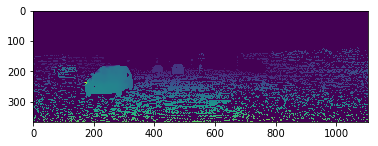

In [320]:
plt.imshow(result[index][0][:,:,0])

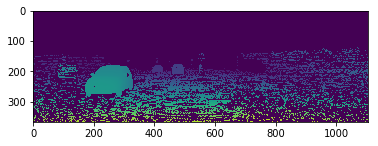

In [321]:
plt.imshow(ground_truth_np_v[index][:,:,0])

In [322]:
#print ((result[index][0][:,:,0]-ground_truth_np_v[index][:,:,0]).max())
print ((abs(result[index][0][:,:,0]-ground_truth_np_v[index][:,:,0])*(ground_truth_np_v[index][:,:,0]>0)).max())

66.1573638916


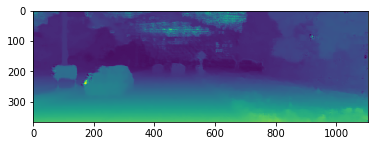

In [323]:
plt.imshow(result_dense[index][0][:,:,0])

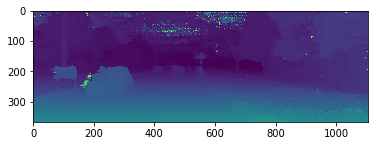

In [324]:
plt.imshow(data_np_v[index][:,:,-1])

In [298]:
print ((abs(data_np_v[index][:,:,-1]-ground_truth_np_v[index][:,:,0])*(ground_truth_np_v[index][:,:,0]>0)).max())

115.9140625


In [299]:
print ((abs(data_np_v[index][:,:,-1]-ground_truth_np_v[index][:,:,0])))

[[  16.6875       16.6875       16.5625     ...,   21.6875       22.0625
    22.5       ]
 [  16.3125       16.1875       16.1875     ...,   20.1875       20.6875
    21.5625    ]
 [  15.875        15.875        15.9375     ...,   23.875        27.3125
    27.1875    ]
 ..., 
 [  61.0625        0.5625       60.9375     ...,   55.0625       55.8125
    54.875     ]
 [   0.296875     61.5           1.30859375 ...,   54.8125       55.1875
   118.1875    ]
 [   1.1796875    61.5625       61.6875     ...,   21.8125       54.8125
   117.1875    ]]


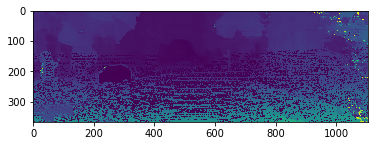

In [300]:
plt.imshow((abs(data_np_v[index][:,:,-1]-ground_truth_np_v[index][:,:,0])))

In [272]:
print(data_np_v[index][100:-100,100:-100,-1].max())

127.0


In [273]:
print (ground_truth_np_v[index][100:-100,100:-100,0].max())

43.20703125


# dummy

In [37]:
print(tmp_ground_true.max(),'laaala')



65.169 laaala


In [38]:
data_np = np.array(data_list)
ground_truth_np = np.array(ground_truth_list)
mask_np = np.array(mask_list)
print(data_np.shape)
print(ground_truth_np.shape)
print(mask_np.shape)

(200, 375, 1240, 13)
(200, 375, 1240, 1)
(200, 375, 1240, 1)


In [31]:
a = abs(tmp_disp-tmp_gt)
print(tmp_disp[200:204,790:794])
print (tmp_gt[200:204,790:794])
print(a[200:204,790:794])

[[ 20.87531853  20.93782043  20.93782043  21.12532234]
 [ 20.93782043  21.12532234  21.12532234  21.18782425]
 [ 20.93782043  21.18782425  21.31282616  21.31282616]
 [ 21.12532234  21.12532234  21.12532234  21.12532234]]
[[  0.          21.49642181  21.73470688   0.        ]
 [ 20.00421143  21.40266991  20.15265083  21.81674004]
 [ 21.71517563  21.76986313   0.          22.00424194]
 [  0.           0.           0.          21.86752129]]
[[ 20.87531853   0.55860138   0.79688644  21.12532234]
 [  0.93360901   0.27734756   0.97267151   0.62891579]
 [  0.77735519   0.58203888  21.31282616   0.69141579]
 [ 21.12532234  21.12532234  21.12532234   0.74219894]]


In [3]:
# get ground truth disparity file list
path_ground_truth = './training'
training_data_folder_path_list= glob.glob('./training/*')
training_data_folder_path_list.sort()
# get disparity file list for to be stacked method
disp_path_eth_list= glob.glob('./InitialResults/training_res_ETHfinetune/*')
disp_path_eth_list.sort()

disp_path_kitti_list= glob.glob('./InitialResults/training_res_Kittifinetune/*')
disp_path_kitti_list.sort()

disp_path_mixed_list= glob.glob('./InitialResults/training_res_mixedfinetune/*')
disp_path_mixed_list.sort()

edge_path_list = glob.glob('./edgesMask_training/*')
edge_path_list.sort()


In [4]:
data_list = []
ground_truth_list = []
mask_list = []

for j in range(len(training_data_folder_path_list)):
    for i in range(len(disp_path_eth_list)):
        count = 0 
        #print(training_data_folder_path_list[j][11:],disp_path_eth_list[i][42:-4])
        #break
        if training_data_folder_path_list[j][11:] == disp_path_eth_list[i][42:-4]:
            #tmp_disp_eth = plt.imread(disp_path_eth_list[i]) *255
            count += 1
        if training_data_folder_path_list[j][11:] == disp_path_kitti_list[i][44:-4]:
            tmp_disp_kitti = plt.imread(disp_path_kitti_list[i])*255
            count += 1
        if training_data_folder_path_list[j][11:] == disp_path_mixed_list[i][44:-4]:
            tmp_disp_mixed = plt.imread(disp_path_mixed_list[i])*255 
            count += 1
        
        if training_data_folder_path_list[j][11:] == edge_path_list[i][26:-4]:
            tmp_edge = plt.imread(edge_path_list[i])*255 
            count += 1
            
            
        if count > 3: 
            left_image = plt.imread(training_data_folder_path_list[j]+'/im0.png') 
            right_image = plt.imread(training_data_folder_path_list[j]+'/im1.png') 
            #warp_kitti = getWarpedImageWithBilinear(right_image,tmp_disp_kitti)
            #warp_eth = getWarpedImageWithBilinear(right_image,tmp_disp_eth)
            warp_mixed = getWarpedImageWithBilinear(right_image,tmp_disp_mixed)
            
            #tmp_combine = np.dstack((left_image,tmp_disp_kitti,tmp_disp_eth,tmp_disp_mixed))
            #tmp_combine = np.dstack((left_image,tmp_disp_mixed))
            #tmp_combine = np.dstack((left_image,tmp_disp_kitti,warp_kitti,tmp_disp_mixed,warp_mixed,tmp_disp_eth,warp_eth))
            #tmp_combine = np.dstack((left_image,tmp_edge,tmp_disp_kitti,warp_kitti,tmp_disp_mixed,warp_mixed))
            tmp_combine = np.dstack((left_image,tmp_edge,tmp_disp_mixed,warp_mixed))
            
            
            data_list.append(tmp_combine)
            tmp_ground_true,_ = readPFM(training_data_folder_path_list[j]+'/disp0GT.pfm')
            ## remove inf
            tmp_ground_true[tmp_ground_true == inf] =0 
            ground_truth_list.append(tmp_ground_true[:,:, newaxis])
            mask_list.append(((tmp_ground_true>0)*1.0)[:,:, newaxis])
            break
    #break

In [5]:
data_np = np.array(data_list)
ground_truth_np = np.array(ground_truth_list)
mask_np = np.array(mask_list)
print(data_np.shape)
print(ground_truth_np.shape)
print(mask_np.shape)

(242,)
(242,)
(242,)


In [6]:
# check if any mismatch happened
for i in range(242):
    if data_np[i].shape[:2] != ground_truth_np[i].shape[:2] \
        or data_np[i].shape[:2] != mask_np[i].shape[:2] \
        or data_np[i].shape[:2] != mask_np[i].shape[:2]:
        print(i)
        print(data_np[i].shape)
        print(ground_truth_np[i].shape)
        print(mask_np[i].shape)

In [7]:
from sklearn.utils import shuffle
data_np, ground_truth_np, mask_np = shuffle(data_np, ground_truth_np, mask_np, random_state=42)
print("complete shuffling")

complete shuffling


In [8]:
print(data_np[0].shape)

(438, 713, 8)


In [9]:

split_point = 180

data_np_t, ground_truth_np_t, mask_np_t = data_np[:split_point], ground_truth_np[:split_point], mask_np[:split_point]
data_np_v, ground_truth_np_v, mask_np_v = data_np[split_point:], ground_truth_np[split_point:], mask_np[split_point:]



In [10]:
def generator_stack(data_np, ground_truth_np, mask_np):
    num_samples = data_np.shape[0]
    while 1: # Loop forever so the generator never terminates
        #data, label =shuffle(data, label, random_state=33)
        for offset in range(0, num_samples): 
            if offset == num_samples - 1:
                data_np, ground_truth_np, mask_np = shuffle(data_np, ground_truth_np, mask_np, random_state=33)
                yield [(data_np[offset])[newaxis,:,:,:],(mask_np[offset])[newaxis,:,:,:]],(ground_truth_np[offset])[newaxis,:,:,:]
                break
            #print(folder_path_list)
            yield [(data_np[offset])[newaxis,:,:,:],(mask_np[offset])[newaxis,:,:,:]],(ground_truth_np[offset])[newaxis,:,:,:]
            
            
            
train_generator = generator_stack(data_np_t, ground_truth_np_t, mask_np_t)
val_generator = generator_stack(data_np_v, ground_truth_np_v, mask_np_v)


In [11]:
print('ok')

ok


# model 

In [12]:
from keras.models import Sequential, load_model, Model
from keras.layers import Input,Activation,  Dense,Conv2D,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPooling2D,BatchNormalization, Dropout
from keras.layers import Add,Subtract,Multiply,Concatenate, Flatten, Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.models import model_from_json

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
# model #glorot_uniform  -> 180
input_shape_c = (None, None,8)
input_shape = (None, None,1)

input_image  = Input(shape=input_shape_c,name='input_image')
mask = Input(shape=input_shape,name='mask')


conv1 = Conv2D(filters = 64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu",name='L1',kernel_initializer='glorot_uniform')(input_image)
conv1 = Conv2D(filters = 32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu",name='L2',kernel_initializer='glorot_uniform')(conv1)
conv1 = Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu",name='L3',kernel_initializer='glorot_uniform')(conv1)


mask_out = Multiply(name='mask_out')([mask,conv1])

model = Model(inputs=[input_image,mask], outputs=mask_out)
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 8 0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, None, None, 6 25152       input_image[0][0]                
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, None, None, 3 51232       L1[0][0]                         
__________________________________________________________________________________________________
mask (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
L3 (Conv2D

In [14]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=18,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=7,
                               verbose=1,
                               min_delta=1e-3),
            ]


In [16]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
#model.fit(x=[data_np,mask_np], y=ground_truth_np, batch_size=1, epochs=10, verbose=1, validation_split=0.1, shuffle=True,callbacks = callbacks)


model.fit_generator(train_generator, steps_per_epoch=split_point , validation_data=val_generator, validation_steps = 242-split_point, epochs=120, callbacks=callbacks, verbose = 1)





Epoch 1/120
180/180 [==============================] - 12s 67ms/step - loss: 0.5139 - val_loss: 0.3154
Epoch 2/120
180/180 [==============================] - 12s 65ms/step - loss: 0.3278 - val_loss: 0.3291
Epoch 3/120
180/180 [==============================] - 12s 65ms/step - loss: 0.4264 - val_loss: 0.6244
Epoch 4/120
180/180 [==============================] - 12s 65ms/step - loss: 0.3367 - val_loss: 0.3109
Epoch 5/120
180/180 [==============================] - 12s 65ms/step - loss: 0.4117 - val_loss: 0.3193
Epoch 6/120
180/180 [==============================] - 12s 66ms/step - loss: 0.5542 - val_loss: 1.0462
Epoch 7/120
180/180 [==============================] - 12s 65ms/step - loss: 0.5207 - val_loss: 0.3832
Epoch 8/120
180/180 [==============================] - 12s 65ms/step - loss: 0.5273 - val_loss: 0.3521
Epoch 9/120
180/180 [==============================] - 12s 65ms/step - loss: 0.3372 - val_loss: 0.3128
Epoch 10/120
180/180 [==============================] - 12s 64ms/step - l

In [51]:
result = []
for i in range(200-split_point):
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    result.append(tmp_r)
print(len(result))

40


In [52]:
result[0].shape

(1, 375, 1240, 1)

In [53]:
result[0][0].shape

(375, 1240, 1)

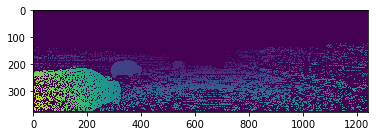

In [24]:
plt.imshow(result[0][0][:,:,0])

In [25]:
ground_truth_np_v[0].shape

(376, 1241, 1)

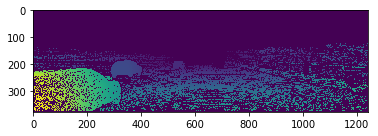

In [26]:
plt.imshow(ground_truth_np_v[0][:,:,0])

In [27]:
np.sum(abs(result[0][0][:,:,0]-ground_truth_np_v[0][:,:,0])>3)/np.sum(ground_truth_np_v[0][:,:,0]>0)

0.045965635292781463

In [28]:
data_np_t[i].shape
ground_truth_np_v[i].shape

(375, 1242, 1)

In [37]:
tmp_combine = np.dstack((left_image,tmp_disp_kitti,warp_kitti,tmp_disp_mixed,warp_mixed))

#E_a= []
K_a = []
M_a = []
Q_a = []
for i in range(split_point):
    
    tmp_r = model.predict([data_np_t[i][newaxis,:,:,:],mask_np_t[i][newaxis,:,:,:]], verbose=0, steps=None)
    K = np.sum(abs(data_np_t[i][:,:,4]*(ground_truth_np_t[i][:,:,0]>0)-ground_truth_np_t[i][:,:,0])>3)/np.sum(ground_truth_np_t[i][:,:,0]>0)
    M = np.sum(abs(data_np_t[i][:,:,8]*(ground_truth_np_t[i][:,:,0]>0)-ground_truth_np_t[i][:,:,0])>3)/np.sum(ground_truth_np_t[i][:,:,0]>0)
    #E = np.sum(abs(data_np_t[i][:,:,11]*(ground_truth_np_t[i][:,:,0]>0)-ground_truth_np_t[i][:,:,0])>3)/np.sum(ground_truth_np_t[i][:,:,0]>0)  
    M_a.append(M)  
    K_a.append(K)
    #E_a.append(E)
    #E = np.sum(abs(data_np_v[i][:,:,3]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    #K = np.sum(abs(data_np_v[i][:,:,4]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    #M = np.sum(abs(data_np_t[i][:,:,3]*(ground_truth_np_t[i][:,:,0]>0)-ground_truth_np_t[i][:,:,0])>3)/np.sum(ground_truth_np_t[i][:,:,0]>0)  
    #M_a.append(M)  
    Q = np.sum(abs(tmp_r[0][:,:,0]*(ground_truth_np_t[i][:,:,0]>0)-ground_truth_np_t[i][:,:,0])>3)/np.sum(ground_truth_np_t[i][:,:,0]>0)
    Q_a.append(Q)  
    #print(K,'\t\t',M,'\t\t',E,'\t\t',Q)
    print(K,'\t\t',M,'\t\t',Q)
    
#print(np.mean(Q_a))
print(np.mean(K_a),np.mean(M_a),np.mean(Q_a))

0.013205436237917943 		 0.0 		 0.005715019349632265
0.00013984759251050175 		 0.0 		 0.0034486944039853924
0.0026606246356918562 		 0.00573491529248068 		 0.008188706917624054
0.009907352862421679 		 0.015878541209232582 		 0.022385262143201416
0.17459368614980572 		 0.04692187961905882 		 0.07982958582201077
0.0011607464839523982 		 0.008181572304363505 		 0.010705914172376487
0.01270103417089379 		 0.03559631945263655 		 0.045436671778538
0.003788472080820738 		 0.010758477562847521 		 0.016622288354608817
0.05404147438055814 		 0.008140387014993365 		 0.030551209174275586
0.0013718765311122 		 0.01019108280254777 		 0.014226537793416774
0.007292858310181402 		 0.07939410034319333 		 0.10259029253145939
0.006158655516071285 		 0.015096053651107489 		 0.01449488337296604
0.00852019752286894 		 0.014065409212337085 		 0.017526107018538007
0.0036142898510311988 		 0.00921268540663442 		 0.010381699037976855
0.004205179448746773 		 0.005629111499708552 		 0.006620034973769673
0.001825104

0.0018654689028145036 		 0.2901528597819394 		 0.3347611113123483
0.006143157964550413 		 0.015187942498051764 		 0.016298850955878696
0.0024512896306843786 		 0.004749373659450983 		 0.006020078945945459
0.17471623247796533 		 0.0001533250630723555 		 0.0029085299843422587
0.16251521708621763 		 0.04475373614143649 		 0.09558369968570393
0.0026187131216633885 		 0.008024726046642314 		 0.011261590334363586
0.019343543209992754 		 0.03207921910445513 		 0.041219160932631754
0.141826495803496 		 0.00019235498503770401 		 0.003082549507059915
0.0014817950889077054 		 0.02639327226541452 		 0.023930028481256253
0.005919006467859795 		 0.022330797128743772 		 0.030154647496260265
0.005485908937872577 		 0.012259125027231497 		 0.017943081219178897
0.003585294147775581 		 0.01691234467993567 		 0.02321221868245562
0.00732819654646095 		 0.016771180051122676 		 0.01730447415362548
0.011688883551499139 		 0.014664478336869353 		 0.01925463352147632
0.004820680240938553 		 0.009393167043729774

In [39]:
tmp_combine = np.dstack((left_image,tmp_disp_kitti,warp_kitti,tmp_disp_mixed,warp_mixed))

E_a= []
K_a = []
M_a = []
Q_a = []
for i in range(242 - split_point):
    
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    K = np.sum(abs(data_np_v[i][:,:,4]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    M = np.sum(abs(data_np_v[i][:,:,8]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    #E = np.sum(abs(data_np_v[i][:,:,11]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
        
    M_a.append(M)  
    K_a.append(K)
    #E_a.append(E)
    Q = np.sum(abs(tmp_r[0][:,:,0]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    Q_a.append(Q)  
    #print(K,'\t\t',M,'\t\t',E,'\t\t',Q)
    
#print(np.mean(Q_a))
print(np.mean(K_a),np.mean(M_a),np.mean(Q_a))

0.03155915530535461 0.02673294429905399 0.03373888460389816


In [47]:
E_a= []
K_a = []
M_a = []
Q_a = []
result = []

for i in range(242-split_point):
    
    tmp_r = model.predict([data_np_v[i][newaxis,:,:,:],mask_np_v[i][newaxis,:,:,:]], verbose=0, steps=None)
    result.append(tmp_r[0])
    K = np.sum(abs(data_np_v[i][:,:,3]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    M = np.sum(abs(data_np_v[i][:,:,4]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    #M = np.sum(abs(data_np_v[i][:,:,5]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    E_a.append(E)  
    K_a.append(K)  
    M_a.append(M)  
    Q = np.sum(abs(tmp_r[0][:,:,0]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)
    Q_a.append(Q)  
    print(E,'\t',K,'\t',M,'\t',Q)
print(np.mean(M_a),np.mean(Q_a))

NameError: name 'E' is not defined

In [26]:
iix = 6
#result.append(tmp_r[0])
#M = np.sum(abs(data_np_v[i][:,:,3]*(ground_truth_np_v[i][:,:,0]>0)-ground_truth_np_v[i][:,:,0])>3)/np.sum(ground_truth_np_v[i][:,:,0]>0)



In [27]:
result[iix].shape

(1, 375, 1242, 1)

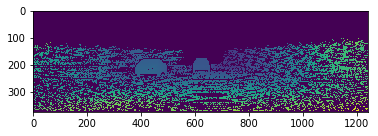

In [31]:
plt.imshow(result[iix][0,:,:,0])

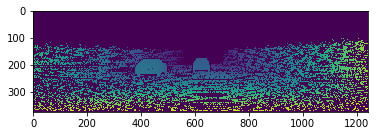

In [29]:
plt.imshow(ground_truth_np_v[iix][:,:,0])

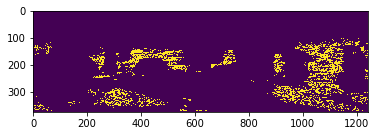

In [32]:
plt.imshow(abs(result[iix][0,:,:,0]*(ground_truth_np_v[iix][:,:,0]>0)-ground_truth_np_v[iix][:,:,0])>3)

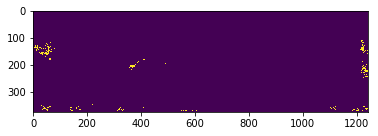

In [177]:
plt.imshow(abs(data_np_v[iix][:,:,3]*(ground_truth_np_v[iix][:,:,0]>0)-ground_truth_np_v[iix][:,:,0])>3)

In [68]:
print(np.mean(E_a),np.mean(K_a),np.mean(Q_a))

nan nan 0.028275282809898394


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
print(np.mean(E_a),np.mean(K_a),np.mean(Q_a))

nan nan 0.028275282809898394


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
sum(sum((tmp_disp_eth*(tmp_ground_true>0)-tmp_ground_true)>3))/sum(sum(tmp_ground_true>0))

0.13277353802466946

In [70]:
print(np.mean(E_a),np.mean(K_a),np.mean(M_a),np.mean(Q_a))

nan nan 0.02673294429905399 0.028275282809898394


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [75]:
print(np.mean(E_a),np.mean(K_a),np.mean(M_a),np.mean(Q_a))

nan nan 0.02673294429905399 0.027597779813781063


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# draft

In [ ]:
path_ground_truth = './training'
#print(glob.glob("/home/adam/*.txt")
training_data_folder_path_list= glob.glob('./training/*')
#print(training_data_folder_path)
print(training_data_folder_path_list[0][11:])

In [ ]:
disp_path_eth_list= glob.glob('./InitialResults/training_res_ETHfinetune/*')
disp_path_eth_list.sort()
print(disp_path_eth_list[0])

disp_path_kitti_list= glob.glob('./InitialResults/training_res_Kittifinetune/*')
disp_path_kitti_list.sort()
print(disp_path_kitti_list[0])


disp_path_mixed_list= glob.glob('./InitialResults/training_res_mixedfinetune/*')
disp_path_mixed_list.sort()
print(disp_path_mixed_list[0])


In [ ]:
for j in range(len(training_data_folder_path_list)):
    print(training_data_folder_path_list[j])
    count = 0 
    for i in range(len(disp_path_eth_list)):
        if training_data_folder_path_list[j][11:] in disp_path_eth_list[i]:
            #print(disp_path_eth_list[i])
            tmp_disp_eth = plt.imread(disp_path_eth_list[i])*255
            #break
            count +=1
        if training_data_folder_path_list[j][11:] in disp_path_kitti_list[i]:
            #print(disp_path_kitti_list[i])
            tmp_disp_kitti = plt.imread(disp_path_kitti_list[i])*255
            count +=1
            #print(count)
        if training_data_folder_path_list[j][11:] in disp_path_mixed_list[i]:
            #print(disp_path_mixed_list[i])
            tmp_disp_mixed = plt.imread(disp_path_mixed_list[i])*255
            count +=1
            #print(count)            
            

    if count <3:
        print(count)
        print(training_data_folder_path_list[j][11:])
        if count ==1:
            break
    else:
        #continue
        tmp_ground_true,_ = readPFM(training_data_folder_path_list[j]+'/disp0GT.pfm')
        left_image = plt.imread(training_data_folder_path_list[j]+'/im0.png')
        print(training_data_folder_path_list[j])
        
    #break

In [ ]:
plt.imshow(tmp_ground_true)

In [ ]:
plt.imshow(left_image)

In [ ]:
print("ETH3d")
print(sum(sum((tmp_disp_eth*(tmp_ground_true>0)-tmp_ground_true)>3))/sum(sum(tmp_ground_true>0)))
print("Kitti")
print(sum(sum((tmp_disp_kitti*(tmp_ground_true>0)-tmp_ground_true)>3))/sum(sum(tmp_ground_true>0)))
print("Mixed")
print(sum(sum((tmp_disp_mixed*(tmp_ground_true>0)-tmp_ground_true)>3))/sum(sum(tmp_ground_true>0)))

In [ ]:
print(tmp_disp_kitti.shape)
#combine = np.dstack((tmp_disp_kitti,tmp_disp_eth,tmp_disp_mixed,left_image))
combine = np.dstack((tmp_disp_kitti,tmp_disp_eth,tmp_disp_mixed))
print(combine.shape)

In [ ]:
print(np.amax(combine))

In [ ]:
plt.imshow(combine[:,:,:]/255)

In [ ]:
plt.imshow(combine[:,:,3:])

In [ ]:
plt.imshow(tmp_ground_true)

In [ ]:
plt.imshow(tmp_disp_kitti)

In [ ]:
plt.imshow(tmp_disp_eth)

In [ ]:
plt.imshow(tmp_disp_mixed)

In [ ]:
plt.imshow(tmp_disp_eth)

In [ ]:
plt.imshow(tmp_disp_kitti)

In [ ]:
d1 = plt.imread('./depth_estimation/finetune_ETH/augmented_Kitti2015_000068_10_im0.png')*255
plt.imshow(d1)

In [ ]:
print(np.amax(d1))